In [1]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load dataset
df = pd.read_csv('2024_clean.csv')

df.sample(5).T

,4765277,4760013,4766621,4761588,4768673
YEAR,2024,2024,2024,2024,2024
MONTH,9,9,9,9,9
DAY_OF_MONTH,30,30,30,30,30
FL_DATE,2024-09-30,2024-09-30,2024-09-30,2024-09-30,2024-09-30
MKT_UNIQUE_CARRIER,UA,F9,WN,UA,WN
MKT_CARRIER_FL_NUM,728,2451,225,1055,510
ORIGIN_CITY_NAME,"Columbus, OH","Charlotte, NC","Chicago, IL","Newark, NJ","San Francisco, CA"
DEST_CITY_NAME,"Denver, CO","Orlando, FL","Tampa, FL","Boston, MA","Los Angeles, CA"
CRS_DEP_TIME,900,2145,750,1400,700
DEP_TIME,854.0,2129.0,748.0,1354.0,702.0


In [3]:
# Define main label and features
main_label = 'ARR_DELAY'
selected_features = ['MKT_UNIQUE_CARRIER', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'DEP_DELAY', 'DISTANCE', 'Day', 'DepTime_sin', 'DepTime_cos']
# Split features into numerical and categorical
numerical_features = df[selected_features].select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df[selected_features].select_dtypes(include=['object']).columns.tolist()

# Automatically distinguish high-cardinality categorical features
low_cardinality_features = [col for col in categorical_features if df[col].nunique() <= 20]
high_cardinality_features = [col for col in categorical_features if df[col].nunique() > 20]

Training LinearRegression...

LinearRegression Evaluation Metrics:
MAE: 5.86
MSE: 56.69
RMSE: 7.53
Training RandomForestRegressor...

RandomForestRegressor Evaluation Metrics:
MAE: 6.13
MSE: 61.56
RMSE: 7.85
Training XGBRegressor...

XGBRegressor Evaluation Metrics:
MAE: 5.80
MSE: 55.92
RMSE: 7.48


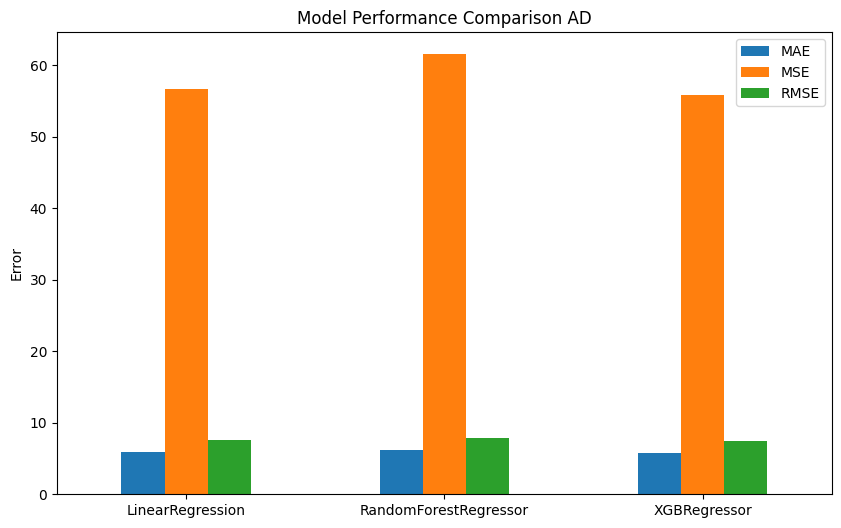

In [4]:
# Split data into train and test
X = df[selected_features]
y = df[main_label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical, low-cardinality, and high-cardinality features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('low_cat', OneHotEncoder(handle_unknown='ignore'), low_cardinality_features),
        ('high_cat', OneHotEncoder(handle_unknown='ignore'), high_cardinality_features)
    ]
)

# Define regression models
models = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'RandomForestRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100))
    ]),
    'XGBRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(objective='reg:squarederror'))
    ])
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    
    # Save the model
    joblib.dump(model, f'{name}_AD_model.pkl')

    # Print evaluation metrics
    print(f"\n{name} Evaluation Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")

# Compare model performances
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison AD")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()

Plotting learning curve for LinearRegression...


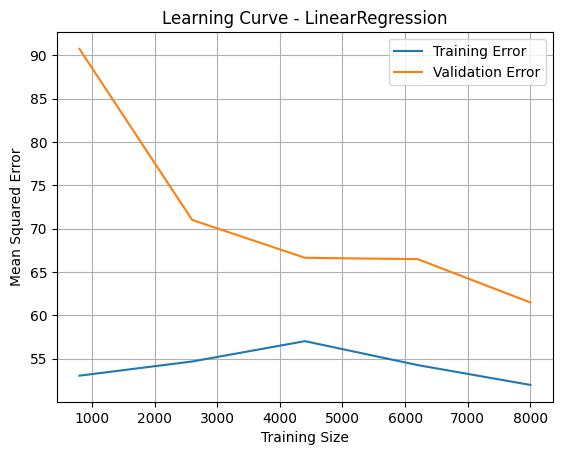

Plotting learning curve for RandomForestRegressor...


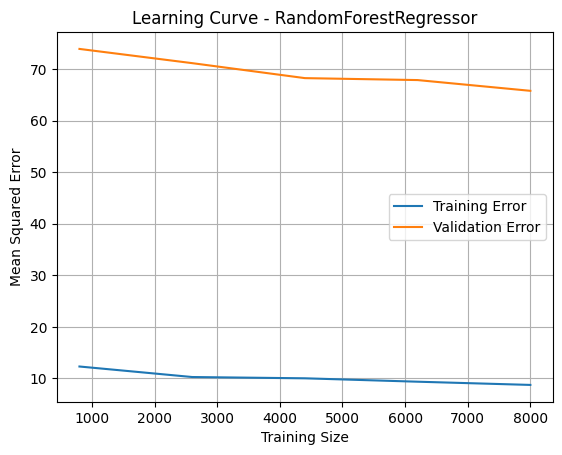

Plotting learning curve for XGBRegressor...


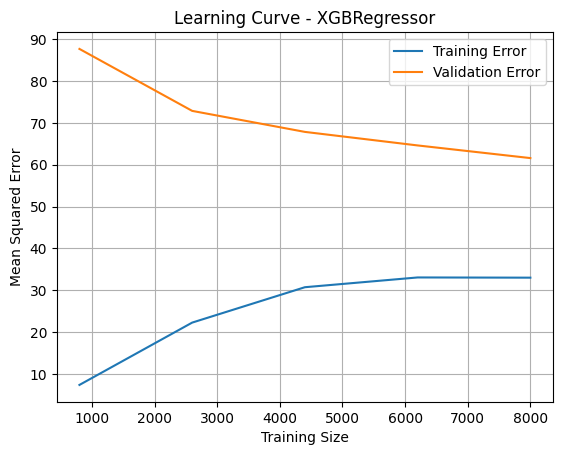

In [5]:
# Plot learning curve for each model
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label="Training Error")
    plt.plot(train_sizes, test_scores_mean, label="Validation Error")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid()
    plt.show()

# Generate learning curves for all models
for name, model in models.items():
    print(f"Plotting learning curve for {name}...")
    plot_learning_curve(model, X, y, f"Learning Curve - {name}")


[0]	validation_0-rmse:14.56347	validation_1-rmse:14.17824
[1]	validation_0-rmse:11.69479	validation_1-rmse:11.46053
[2]	validation_0-rmse:9.93399	validation_1-rmse:9.87158
[3]	validation_0-rmse:8.88382	validation_1-rmse:8.96226
[4]	validation_0-rmse:8.27915	validation_1-rmse:8.47756
[5]	validation_0-rmse:7.91651	validation_1-rmse:8.19403
[6]	validation_0-rmse:7.68566	validation_1-rmse:8.02402
[7]	validation_0-rmse:7.54891	validation_1-rmse:7.92681
[8]	validation_0-rmse:7.45093	validation_1-rmse:7.86535
[9]	validation_0-rmse:7.33412	validation_1-rmse:7.80292
[10]	validation_0-rmse:7.26119	validation_1-rmse:7.76332
[11]	validation_0-rmse:7.20746	validation_1-rmse:7.74393
[12]	validation_0-rmse:7.16443	validation_1-rmse:7.72328
[13]	validation_0-rmse:7.11516	validation_1-rmse:7.71593
[14]	validation_0-rmse:7.08607	validation_1-rmse:7.69140
[15]	validation_0-rmse:7.02488	validation_1-rmse:7.66584
[16]	validation_0-rmse:6.98632	validation_1-rmse:7.63337
[17]	validation_0-rmse:6.96751	valida

D:\Anaconda3\envs\General\Lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[73]	validation_0-rmse:5.95522	validation_1-rmse:7.47713
[74]	validation_0-rmse:5.94607	validation_1-rmse:7.47922
[75]	validation_0-rmse:5.92870	validation_1-rmse:7.47407
[76]	validation_0-rmse:5.92025	validation_1-rmse:7.47044
[77]	validation_0-rmse:5.91638	validation_1-rmse:7.47014
[78]	validation_0-rmse:5.91112	validation_1-rmse:7.46993
[79]	validation_0-rmse:5.90733	validation_1-rmse:7.47388
[80]	validation_0-rmse:5.89836	validation_1-rmse:7.47704
[81]	validation_0-rmse:5.89512	validation_1-rmse:7.47705
[82]	validation_0-rmse:5.88958	validation_1-rmse:7.47479
[83]	validation_0-rmse:5.87839	validation_1-rmse:7.47597
[84]	validation_0-rmse:5.86064	validation_1-rmse:7.47344
[85]	validation_0-rmse:5.85535	validation_1-rmse:7.47386
[86]	validation_0-rmse:5.84878	validation_1-rmse:7.47541
[87]	validation_0-rmse:5.84495	validation_1-rmse:7.47487
[88]	validation_0-rmse:5.81276	validation_1-rmse:7.46979
[89]	validation_0-rmse:5.80852	validation_1-rmse:7.46976
[90]	validation_0-rmse:5.78814	

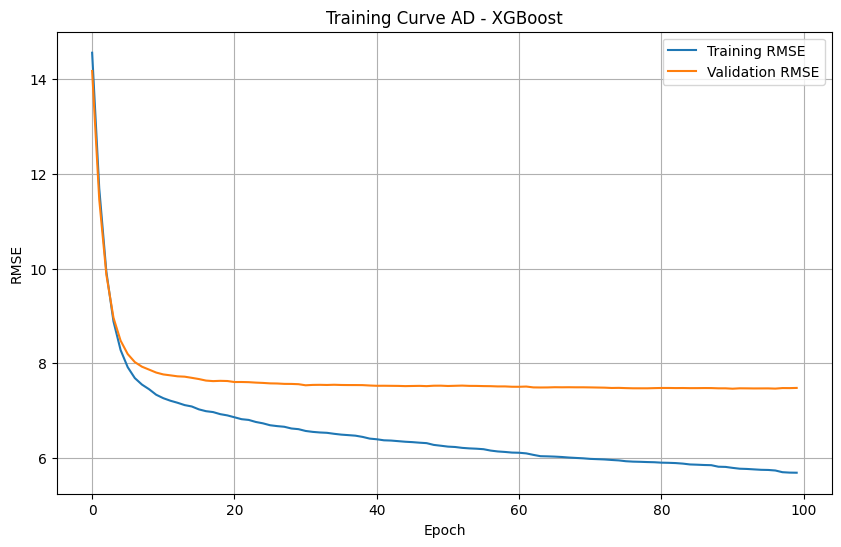

In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Combine the preprocessor and XGBoost model into a Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Use ColumnTransformer for preprocessing
    ('regressor', XGBRegressor(objective='reg:squarederror', eval_metric='rmse'))
])

# Train the model with the pipeline and enable evaluation monitoring
xgb_pipeline.fit(X_train, y_train)

# Get preprocessed data (optional, useful for manual evaluation)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Manually call XGBoost's eval_set to monitor performance during training
xgb_model = xgb_pipeline.named_steps['regressor']
xgb_model.fit(
    X_train_processed, y_train,
    eval_set=[(X_train_processed, y_train), (X_test_processed, y_test)],
    early_stopping_rounds=50,  # Stop if no improvement for 50 rounds
    verbose=True
)

# Print evaluation results
results = xgb_model.evals_result()

# Visualize training curve
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='Training RMSE')
plt.plot(results['validation_1']['rmse'], label='Validation RMSE')
plt.title('Training Curve AD - XGBoost')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()


Performing cross-validation for LinearRegression...
LinearRegression - Mean MSE: 61.47, Std: 12.56
Performing cross-validation for RandomForestRegressor...
RandomForestRegressor - Mean MSE: 65.71, Std: 13.03
Performing cross-validation for XGBRegressor...
XGBRegressor - Mean MSE: 61.58, Std: 13.25


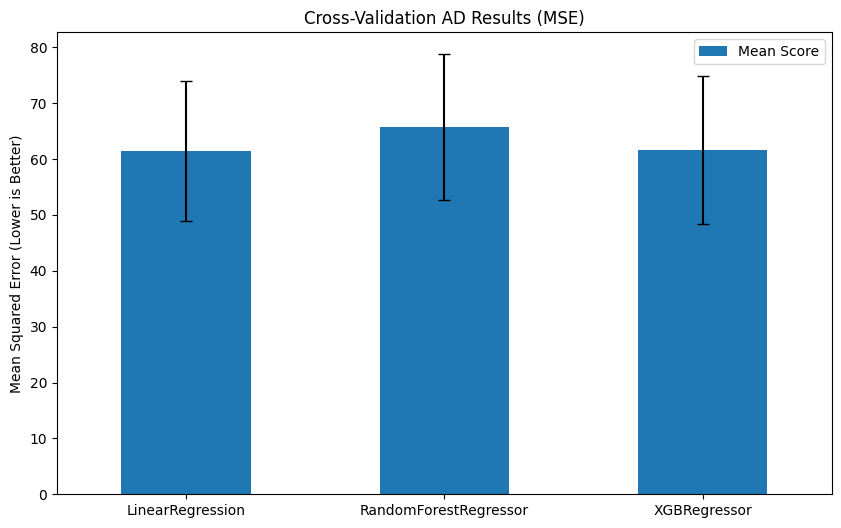

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, cross_validate

# Define the scoring metric
scoring = 'neg_mean_squared_error'  # Or other regression metrics, such as 'r2' or 'neg_mean_absolute_error', "neg_mean_squared_error"

# Perform cross-validation for all models
cv_results = {}
for name, model in models.items():
    print(f"Performing cross-validation for {name}...")
    scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs=-1)
    cv_results[name] = {
        'Mean Score': -np.mean(scores),  # Negate to convert negative MSE to positive MSE
        'Std Deviation': np.std(scores)
    }
    print(f"{name} - Mean MSE: {-np.mean(scores):.2f}, Std: {np.std(scores):.2f}")

# Display results
cv_df = pd.DataFrame(cv_results).T
cv_df.plot(kind='bar', figsize=(10, 6), y='Mean Score', yerr='Std Deviation', capsize=4)
plt.title("Cross-Validation AD Results (MSE)")
plt.ylabel("Mean Squared Error (Lower is Better)")
plt.xticks(rotation=0)
plt.show()

Performing cross-validation for LinearRegression...
LinearRegression - Mean R2: 0.79, Std: 0.03
Performing cross-validation for RandomForestRegressor...
RandomForestRegressor - Mean R2: 0.78, Std: 0.03
Performing cross-validation for XGBRegressor...
XGBRegressor - Mean R2: 0.79, Std: 0.03


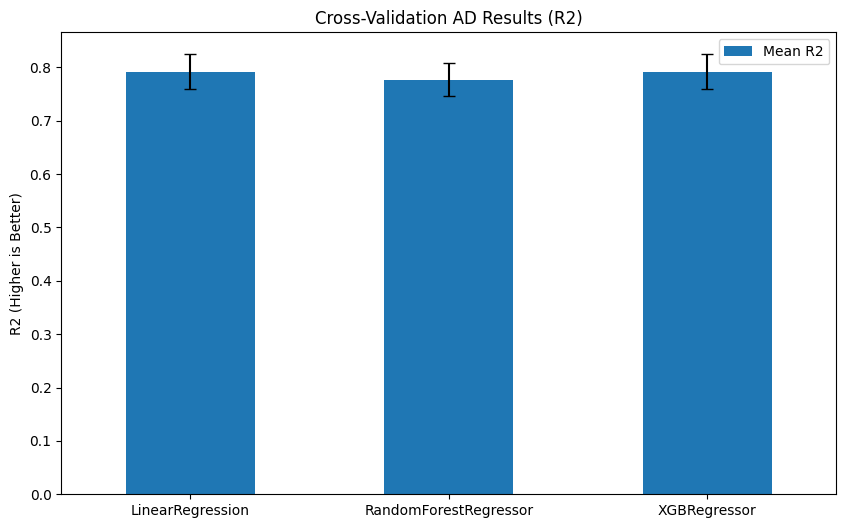

In [8]:
from sklearn.metrics import r2_score

# Train and evaluate models with R2
cv_results = {}
for name, model in models.items():
    print(f"Performing cross-validation for {name}...")
    scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)  # Use R2 as scoring metric
    cv_results[name] = {
        'Mean R2': np.mean(scores),
        'Std Deviation': np.std(scores)
    }
    print(f"{name} - Mean R2: {np.mean(scores):.2f}, Std: {np.std(scores):.2f}")

# Visualize R2 results
cv_df = pd.DataFrame(cv_results).T
cv_df.plot(kind='bar', figsize=(10, 6), y='Mean R2', yerr='Std Deviation', capsize=4)
plt.title("Cross-Validation AD Results (R2)")
plt.ylabel("R2 (Higher is Better)")
plt.xticks(rotation=0)
plt.show()
